# Ray Tracer for Cold Magnetised Plasma (Apple Hartree Dispersion for O- and X-mode)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import matplotlib as mpl
from scipy.integrate import solve_ivp

In [2]:
# %matplotlib qt

In [3]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

**Current Status**

I have now changed the implementation, such that one can give a position dependent $\vec{B}$-field (instead of simply defining an angle $\theta$ between $\vec{k}$ and $\vec{B}$).

I experienced numerical performance problems when defining a $B$-field with $\theta \approx 0$.

Currently this is solved by detaching the $r$ and $k$ vectors when calculating $B$ and $\theta$.

In our simple case, $\theta$ is the same everywhere, but in general, the dependency of $\theta$ on $r$ should be taken into account when calculating the gradients of the dispersion relation.

**Amplitudes of the E-field**

As a next step, I would like to calculate the amplitudes of the $E$-field.

My first attempt at this was to simply calculate the null space of the matrix in Eq. (2.31).

This seemed to work for two of the runs (an O-mode starting at the edge of the plasma and an X-mode starting inside the plasma), but I did not get it to work in general.
I think the problem is,
1. The dispersion relation is only approximately satisfied, so the null-space does not map to 0 exactly.
2. When allowing significant slack in the null-space condition, we get all three eigenvectors, and we have no guarantee on the order of these, so we might accidently be selecting an O-mode null-vector instead of an X-mode null-vector.

Also this attempt only works for $\theta=90^\circ$. 

**Next Steps**

Calculate E-fields by applying general coordinate transformation and using the polarisation in Eq. (2.63).

In [4]:
# Define Apple-Hartree dispersion relation
import torch

e = 1.0
eps_0 = 1.0
m_e = 1.0
c = 1.0
q = 1.0

def to_torch(*vars, dtype='torch.FloatTensor', detach=False):
    def convert(var):
        if isinstance(var, torch.Tensor):
            T = var.type(dtype)
        else:
            T = torch.tensor(var).type(dtype)
        if detach:
            return T.detach()
        else:
            return T
    if len(vars) == 1:
        return convert(vars[0])
    else:
        return (convert(var) for var in vars)

def to_torch_3D(*vars, dtype='torch.FloatTensor', detach=False):
    def convert(var):
        return var.reshape(3, -1)
    if len(vars) == 1:
        return to_torch(convert(vars[0]), dtype=dtype, detach=detach)
    else:
        return to_torch(*(convert(var) for var in vars), dtype=dtype, detach=detach)

def inner_product(a, b):
    if len(a.shape) == 2:
        return torch.matmul(torch.t(a), b).diagonal()
    else:
        return torch.dot(a, b)

def angle(a, b):
    a, b = to_torch_3D(a, b)
    return torch.acos(inner_product(a, b)/(torch.norm(a, dim=0)*torch.norm(b, dim=0)))

def B_from_theta(theta):
    '''Returns function B_0(r) defining the B-field for position r'''
    _theta = to_torch(theta, detach=True)
    def B_0(r):
        r = to_torch_3D(r, detach=True)
        B0 = 0.4
        return B0 * torch.tensor([torch.cos(_theta), 0, torch.sin(_theta)]).reshape(3, -1).repeat(1, r.shape[-1])
    return B_0

# Currently set B_0 with theta = 90 deg.
B_0 = B_from_theta(torch.pi/2)

def get_theta(r, k_dir):
    r, k_dir = to_torch_3D(r, k_dir, detach=True)
    return angle(B_0(r), k_dir)

def omega_c(r):
    r = to_torch_3D(r, detach=True)
    return q*torch.norm(B_0(r), dim=0)/m_e

def n_e(r):
    r = to_torch_3D(r)
    x, y, z = r
    return x

def omega_p_squared(r):
    r = to_torch_3D(r)
    return n_e(r) * e**2 / (eps_0 * m_e)

def X(r, omega):
    r = to_torch_3D(r)
    return omega_p_squared(r)/(omega**2)

def Y(r, omega):
    r = to_torch_3D(r)
    omega = to_torch(omega)
    x, y, z = r
    return torch.ones(x.shape)*omega_c(r)/omega

def N(k, omega):
    k = to_torch_3D(k)
    omega = to_torch(omega)
    return c/omega * k

def denominator(X, Y, theta, mode):
    def Gamma(X, Y, theta, mode):
        sign = -1
        if mode == 'O':
            sign = 1
        return sign * torch.sqrt(Y**4 * (torch.sin(theta)**4)
            + 4*(Y**2)*((1-X)**2) * (torch.cos(theta)**2))
    
    return (2*(1-X)
        - Y**2*(torch.sin(theta)**2)
        + Gamma(X, Y, theta, mode))

def N_squared(r, omega, theta, mode):
    r = to_torch_3D(r)
    omega, _theta = to_torch(omega, theta)
    _X = X(r, omega)
    _Y = Y(r, omega)
    return 1 - 2*_X*(1-_X)/denominator(_X, _Y, _theta, mode)

def D(r, k, omega, mode):
    r, k = to_torch_3D(r, k)
    _theta = get_theta(r, k)
    _X = X(r, omega)
    _Y = Y(r, omega)
    _N = torch.norm(N(k, omega))
    return (denominator(_X, _Y, _theta, mode) * (1 - _N**2)
        - 2 * _X * (1-_X))

# NumPy Functions
def k_from_dir(k_dir, r, omega, mode):
    '''Returns k-vector in specified direction satisfying dispersion relation'''
    k_hat = k_dir/np.linalg.norm(k_dir)
    _theta = get_theta(r, k_dir).detach().numpy()
    N = np.emath.sqrt(N_squared(r, omega, theta=_theta, mode=mode).detach().numpy())
    return (N*omega/c)*k_hat

In [5]:
# Ray tracer function.

def trace_ray(r0, k_dir, omega0, tmin, tmax, mode='O', rtol=1e-3, r_min=torch.tensor([0, 0, 0]), r_max=torch.tensor([1000,1000,1000])):
    '''Solves ray-tracer equation for O or X mode in a cold plasma using the Apple-Hartree dispersion relation
    Parameters
    ----------
    r0: np.ndarray
        Start position of ray
    k_dir: np.ndarray
        Initial ray direction. The vector is rescaled such that it satisfies the dispersion relation at the given position.
    omega0: float
        Frequency
    tmin, tmax: (float, float)
        simulation start and end time
    mode: 'O' or 'X'
        choose ordinary or extraordinary mode
    rtol:
        relative tolerance parsed to scipy.integrate.solve_ivp
    rmin, rmax: (float, float)
        Boundaries of domains. Ray propagation is stopped when it reaches the boundaries.

    Returns
    -------
        solution from scipy.integrate.solve_ivp method
    '''
    k0 = k_from_dir(k_dir, r0, omega0, mode)
    q0 = np.hstack((r0,k0))

    def is_in_domain(r):
        ''' Returns 0.0 if ray exceeds boundary'''
        return torch.prod(torch.heaviside(r-r_min, torch.ones_like(r)))*torch.prod(torch.heaviside(r_max-r, torch.ones_like(r)))

    # RHS of ray-tracer ODE
    def f(t, q):
        x, y, z, kx, ky, kz = q
        omega = torch.tensor(omega0, requires_grad=True)
        r = torch.tensor([x, y, z], requires_grad=True)
        k = torch.tensor([kx, ky, kz], requires_grad=True)

        Di = D(r, k, omega, mode)
        Di.backward()
        grad_r = r.grad
        grad_k = k.grad
        grad_omega = omega.grad
        RHS_r = - grad_k/grad_omega * is_in_domain(r)
        RHS_k = grad_r/grad_omega* is_in_domain(r)
        
        return torch.hstack((RHS_r, RHS_k)).detach().numpy()

    sol = solve_ivp(f, [tmin, tmax], q0, t_eval = np.linspace(tmin,tmax, 100), rtol=rtol, atol = (1e-3)*rtol)
    return sol

### CMA-Diagrams for O- and X-modes at different angles

In [6]:
def X_UH(Y, theta):
    return (1 - Y**2)/(1-Y**2 * np.cos(theta)**2)

def Y_UH(X, theta):
    return np.sqrt((1-X)/(1-X*np.cos(theta)**2))

def plot_CMA(ax, theta, xlim=(0,2), ylim=(0,2), include_txt_annotations=True):
    X_arr = np.linspace(xlim[0], xlim[1], 1000)
    Y_arr = np.linspace(ylim[0], ylim[1], 1000)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r'$\omega_p^2/\omega^2 \propto n_e$')
    ax.set_ylabel(r'$\omega_{ce}^2/\omega^2 \propto B$')
    ax.grid()

    # Plasma frequency (O-cutoff)
    ax.vlines(1, ylim[0], ylim[1], 'k', linestyles='dashed')

    # Cyclotron frequency (Resonance)
    ax.plot(X_arr, np.ones_like(X_arr), 'k')

    if theta > 0:
        # Upper hybrid resonance
        ax.plot(X_arr[X_arr < 1], Y_UH(X_arr[X_arr < 1], theta), '-k')

    # R-cutoff (X-cutoff)
    ax.plot(X_arr, 1 - X_arr, '--k')

    # L-cutoff (X-cutoff)
    ax.plot(X_arr, X_arr - 1, '--k')

    if include_txt_annotations:
        pct_x = np.diff(xlim)/100
        pct_y = np.diff(ylim)/100
        ax.text(1 + 1.5*pct_x, 70*pct_y, r'$\omega = \omega_p$', rotation=90)
        ax.text(1 + 16*pct_x, 1 + 3.5*pct_y, r'$\omega = \omega_{ce}$')
        if theta > 0:
            small_theta = (theta < 15*np.pi/180)
            ax.text(22*pct_x + small_theta*0.1, 27.5*pct_y + small_theta*0.1, r'$\omega = \omega_\mathrm{UH}$', rotation=-35)
        ax.text(2.5*pct_x, 25*pct_y, r'$\omega = \omega_R$', rotation=-45)
        ax.text(1 + 25*pct_x, 20*pct_y, r'$\omega = \omega_L$', rotation=45)

def plot_vlines_cutoffs_and_resonances(ax, Y, theta, ylim=(-1.5,1.5)):
    ax.vlines(1, ylim[0], ylim[1], 'k', linestyle='dashed')
    ax.vlines(X_UH(Y, theta), ylim[0], ylim[1], 'k', linestyle='solid')
    ax.vlines(1-Y, ylim[0], ylim[1], 'k', linestyle='dashed')
    ax.vlines(1+Y, ylim[0], ylim[1], 'k', linestyle='dashed')

def plot_Nsquared_vs_X(ax, Y, theta, omega0, xlim=(0,2), ylim=(-1.5,1.5)):
    X_arr = np.linspace(xlim[0], xlim[1], 1000)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.set_xlabel(r'$\omega_p^2/\omega^2 \propto n_e$')
    ax.set_ylabel(r'$N^2$')
    r_arr = np.array([X_arr, np.zeros_like(X_arr), np.zeros_like(X_arr)])
    ax.plot(X_arr, N_squared(torch.tensor(r_arr), omega0, theta, mode='O'), '--', color='tab:red')
    ax.plot(X_arr, N_squared(torch.tensor(r_arr), omega0, theta, mode='X'), '--', color='tab:blue')
    plot_vlines_cutoffs_and_resonances(ax, Y, theta, ylim)
    ax.fill_between(X_arr, ylim[0], 0, color='gainsboro')
    ax.text(1 - Y - 0.13, -1.3, r'$\omega = \omega_R$', rotation=90)
    ax.text(X_UH(Y, theta) - 0.13, 0.5, r'$\omega = \omega_{\mathrm{UH}}$', rotation=90)
    ax.text(1 + 0.02, -1.3, r'$\omega = \omega_p$', rotation=90)
    ax.text(1+Y + 0.02, -1.3, r'$\omega = \omega_L$', rotation=90)
    ax.grid()

def plot_x_vs_t_axis(ax, Y, theta, xlim, ylim):
    ax.invert_yaxis()
    ax.set_xlim(xlim)
    ax.grid()
    ax.set_xlabel(r'$\omega_p^2/\omega^2 \propto n_e$')
    ax.set_ylabel(r'$t$')
    plot_vlines_cutoffs_and_resonances(ax, Y, theta=theta, ylim=ylim)

In [7]:
theta_degs = [90, 30, 10, 0]
thetas = [theta_deg*np.pi/180 for theta_deg in theta_degs]
omega0 = 1.0

x0s = [0.0, 0.0, 1 + Y(np.zeros(3), omega0).detach().numpy()[0] - 0.04]
r0s = [np.array([x0, 1.0, 1.0]) for x0 in x0s]
k_dirs = [np.array([1.0, 0.0, 0.0]), np.array([1.0, 0.0, 0.0]), np.array([-1.0, 0.0, 0.0])]
modes = ['X', 'O', 'X']
labels = ['X', 'O', '']
colors = ['tab:blue', 'tab:red', 'tab:blue']

sols_for_theta = []

for theta in thetas:
    sols = []
    B_0 = B_from_theta(theta)
    for i, r0 in enumerate(r0s):
        sol = trace_ray(r0, k_dirs[i], omega0, tmin=0, tmax=5, mode=modes[i], rtol=1e-4)
        x, y, z, kx, ky, kz = sol.y
        r = np.array([x, y, z])
        k = np.array([kx, ky, kz])
        sols.append({
            'sol': sol,
            't': sol.t,
            'r': r,
            'k': k
        })
    sols_for_theta.append(sols)

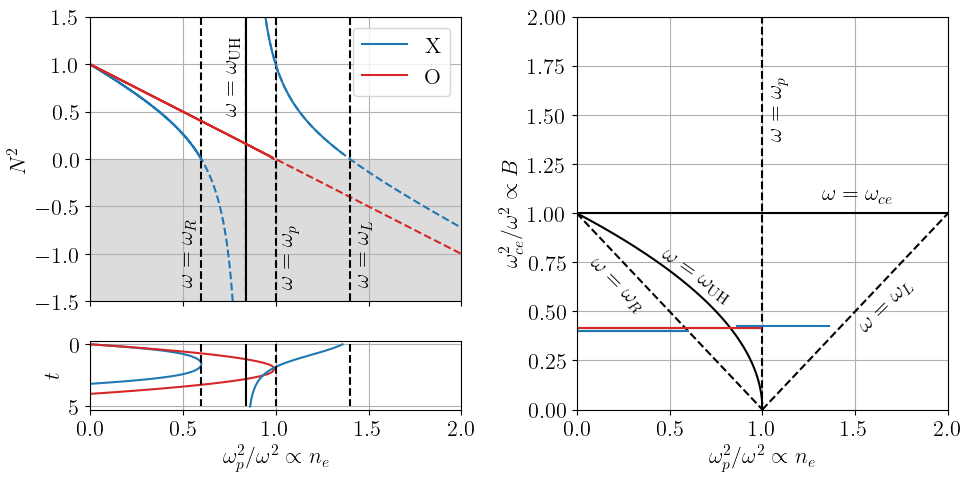

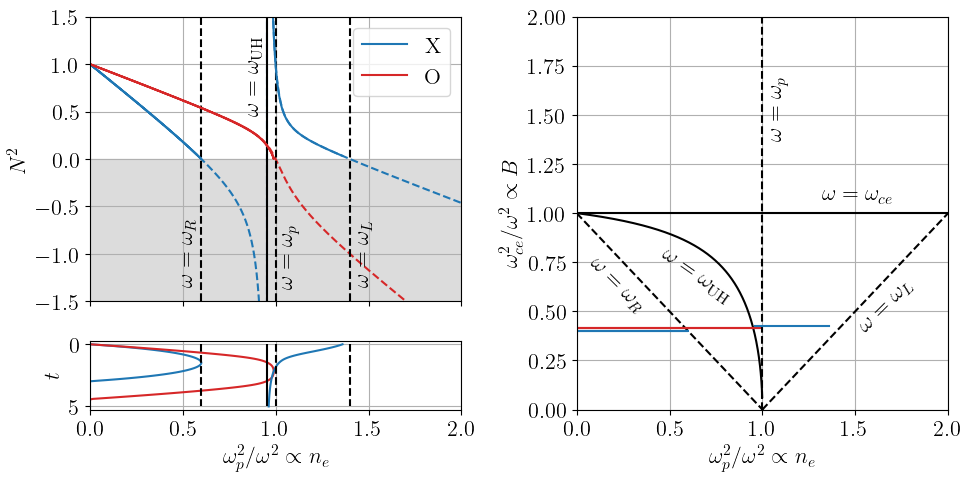

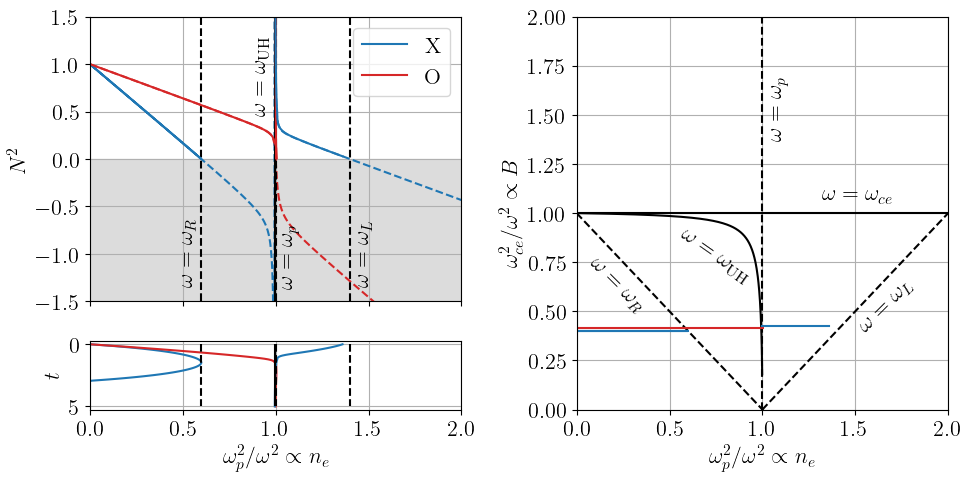

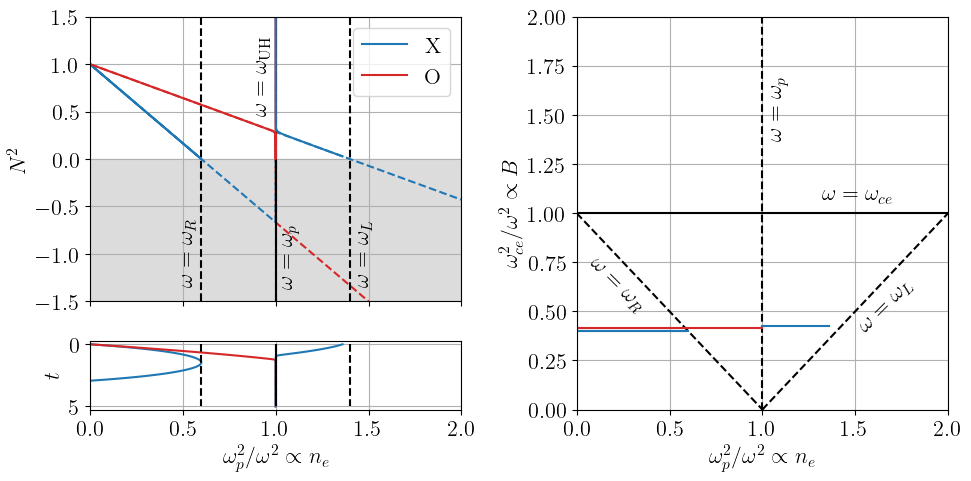

In [8]:
for j, _theta in enumerate(thetas):
   theta_deg = theta_degs[j]
   sols = sols_for_theta[j]

   fig = plt.figure(figsize=(10,5.1))
   gs = mpl.gridspec.GridSpec(4, 2, figure=fig)
   ax0 = fig.add_subplot(gs[:3,0])
   ax1 = fig.add_subplot(gs[:,1])
   ax2 = fig.add_subplot(gs[3:,0])
   ax0.sharex(ax2)
   plt.setp(ax0.get_xticklabels(), visible=False)

   xlim = (0, 2)
   plot_Nsquared_vs_X(ax0, Y(r0s[0], omega0), theta=_theta, omega0=omega0, xlim=xlim)
   plot_CMA(ax1, theta=_theta, xlim=xlim)

   for i, r0 in enumerate(r0s):
      sol, t, r, k = sols[i]['sol'], sols[i]['t'], sols[i]['r'], sols[i]['k']
      x, y, z = r
      _N = np.linalg.norm(N(k, omega0),axis=0)

      ax0.plot(x, _N**2, color=colors[i], label=labels[i])

      ylim = (0,2)
      ax1.plot(X(r, omega0), Y(r, omega0) + np.diff(ylim)/150*i, color=colors[i])
      
      ax2.plot(x, sol.t, color=colors[i])
   plot_x_vs_t_axis(ax2, Y(r0s[0], omega0), _theta, xlim=xlim, ylim=(sol.t.min(), sol.t.max()))

   ax0.legend()
   # plt.subplots_adjust(top=0.85)
   # fig.suptitle(r'Dispersion with $\theta = ' + str(theta_deg) + '^{\circ}$')
   fig.tight_layout()
   # fig.savefig('./plots/cold_trace__theta_' + str(theta_deg) + '.png', dpi=600)
   # fig.savefig('./plots/cold_trace__theta_' + str(theta_deg) + '.pdf')
   plt.show()

### Amplitude of Electric Field

In [16]:
from scipy.linalg import null_space

# def null_space(A, atol=1e-1):
#     w, v = np.linalg.eig(A)
#     return v[:,np.isclose(w, 0, atol=atol)]

def cross(a, M):
    '''Calculates Cross vector with matrix
    Corresponds to writing matrix as outer products
    and calculating the cross product from the left.
    '''
    if isinstance(a, np.ndarray):
        return np.cross(a, M, axis=0)
    return torch.cross(torch.vstack((a, a, a)).mT, M)

def eps(r, omega):
    _X = X(r, omega)
    _Y = Y(r, omega)
    eps_11 = 1 - _X/(1-_Y**2)
    eps_12 = 1j*(_X*_Y)/(1-_Y**2)
    eps_33 = 1 - _X
    return torch.tensor([
        [eps_11, eps_12, 0],
        [-eps_12, eps_11, 0],
        [0, 0, eps_33],
    ])

def wave_operator(r, k, omega):
    r, k, omega = to_torch(r, k, omega)
    I = torch.eye(3) # identity
    return cross(k, cross(k, I)) + (omega**2/(c**2)) * eps(r0, omega0)

def E(r, k, omega, mode):
    r, omega = to_torch(r, omega)
    _X = X(r, omega)
    _Y = Y(r, omega)

def E(r, k, omega, mode):
    wave = wave_operator(r,k,omega).detach().numpy()
    w, v = np.linalg.eig(wave)
    _E = v[:, np.argsort(w)[int(mode == 'O')]]
    return _E
    # _E = null_space(wave_operator(r,k,omega), rcond=1)
    # idx = {'O': 1, 'X': 2}
    # # if _E.shape[-1] > 1:
    # #     return _E[:,int(mode == 'X')]
    # return _E[idx[mode]]

def X_Y_E1_over_E2(r, omega):
    r, omega = to_torch(r, omega)
    _X = X(r, omega)
    _Y = Y(r, omega)
    return -1j*(1-_X - _Y**2)

def E1_over_E2(r, omega):
    r, omega = to_torch(r, omega)
    _X = X(r, omega)
    _Y = Y(r, omega)
    out = (1j*(1-_X - _Y**2)/(_X*_Y))
    out[_X < 1e-1] = 0
    out[_Y < 1e-1] = 0
    return out

In [18]:
# i_theta = 0
# i_run = 0
# sol = sols_for_theta[i_theta][i_theta]
# t = sol['t']
# r = sol['r']
# k = sol['k']

# for i_t in [0, 1, 20]:
#     print('---------------------------')
#     print('i_t =', i_t)
#     t0 = t[i_t]
#     r0 = r[:,i_t]
#     k0 = k[:,i_t]
#     A = wave_operator(r0, k0, omega0)

#     print('**From Eigenvalues**')
#     w, v = np.linalg.eig(A)
#     print('w:', w, '\nv:', v)
#     print('null space:\n', v[:,np.isclose(w, 0, atol=1)])

#     print('**From scipy**')
#     print('null space:\n', null_space(A, rcond=1))

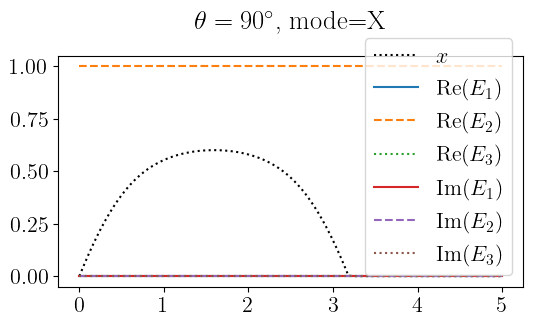

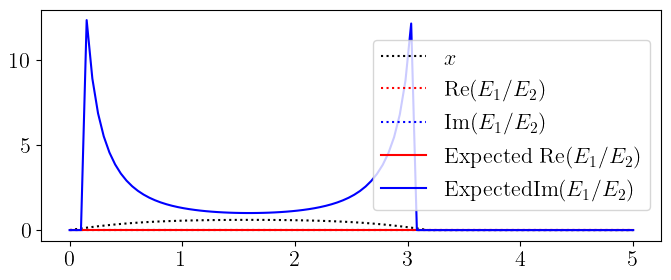

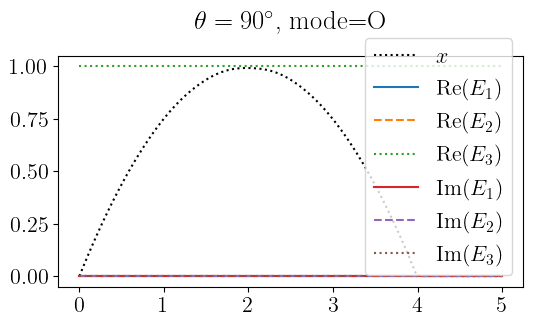

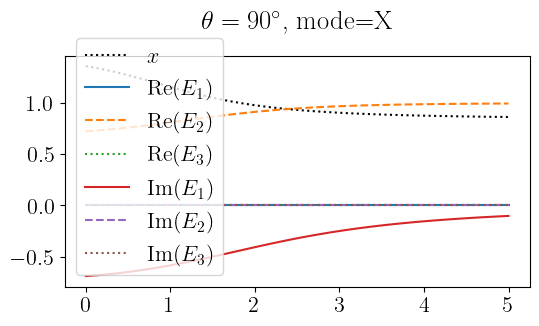

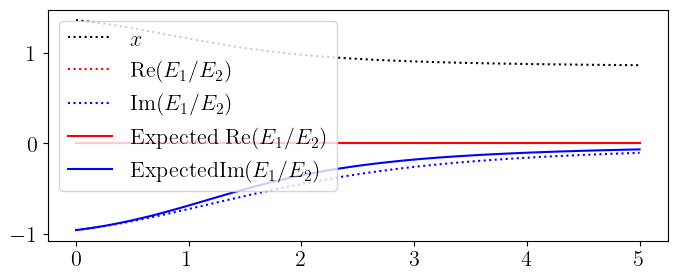

In [11]:
for i_theta, theta in enumerate(thetas[:1]):
    theta_deg = theta_degs[i_theta]
    sols = sols_for_theta[i_theta]

    
    for i_run, r0 in enumerate(r0s):
        mode = modes[i_run]
        sol, t, r, k = sols[i_run]['sol'], sols[i_run]['t'], sols[i_run]['r'], sols[i_run]['k']
        x, y, z = r
        _N = np.linalg.norm(N(k, omega0),axis=0)
        Es = np.zeros_like(r, dtype=np.complex_)
        # print('\n-----------------', 'i_run', i_run, 'mode: ', modes[i_run], '\n-----------------')
        for i_t in range(r.shape[-1]):
            # if len(E(r[:,i_t], k[:,i_t], omega0, mode='X')) != 3:
            #     print(len(E(r[:,i_t], k[:,i_t], omega0, mode='X')))
            # try:
            Es[:,i_t] = E(r[:,i_t], k[:,i_t], omega0, mode=modes[i_run])
        
        plt.figure(figsize=(6,3))
        plt.title(r'$\theta = ' + str(theta_deg) + '^\circ$, mode=' + modes[i_run])
        # exp = np.exp(1j*(np.dot(r.T, k).diagonal()-omega0*t))
        # exp = np.exp(1j*(-omega0*t))
        # E1, E2, E3 = np.real(Es*exp)
        E1, E2, E3 = Es
        plt.plot(t, x, ':k', label=r'$x$')
        plt.plot(t, np.real(E1), '-', label=r'$\mathrm{Re}(E_1)$')
        plt.plot(t, np.real(E2), '--', label=r'$\mathrm{Re}(E_2)$')
        plt.plot(t, np.real(E3), ':', label=r'$\mathrm{Re}(E_3)$')
        plt.plot(t, np.imag(E1), '-', label=r'$\mathrm{Im}(E_1)$')
        plt.plot(t, np.imag(E2), '--', label=r'$\mathrm{Im}(E_2)$')
        plt.plot(t, np.imag(E3), ':', label=r'$\mathrm{Im}(E_3)$')
        # plt.plot(t, np.real(E1/np.maximum(E3,1e-5)), '-', color='tab:purple')
        # plt.plot(t, np.imag(E1/np.maximum(E3,1e-5)), ':', color='tab:purple')
        plt.legend()
        
        if mode == 'X':
            plt.figure(figsize=(8,3))
            plt.plot(t, x, ':k', label=r'$x$')
            plt.plot(t, np.real(E1/E2), ':r', label=r'$\mathrm{Re}(E_1/E_2)$')
            plt.plot(t, np.imag(E1/E2), ':b', label=r'$\mathrm{Im}(E_1/E_2)$')
            plt.plot(t, torch.real(E1_over_E2(r, omega0)), 'r', label=r'Expected $\mathrm{Re}(E_1/E_2)$')
            plt.plot(t, torch.imag(E1_over_E2(r, omega0)), 'b', label=r'Expected$\mathrm{Im}(E_1/E_2)$')
            plt.legend()

        # plt.figure()
        # plt.title(r'imag $\theta = ' + str(theta_deg) + '^\circ$, mode=' + modes[i_run])
        # plt.plot(np.imag(Es[0,:]), color='black', label=r'$E_1$')
        # plt.plot(np.imag(Es[1,:]), color='tab:blue', label=r'$E_2$')
        # plt.plot(np.imag(Es[2,:]), color='tab:red', label=r'$E_3$')
            # try:
            #     Es[:,i] = E(r[:,i_t], k[:,i_t], omega0, mode=modes[i_run])
            # except:
            #     print(i_run, modes[i_run], i_t)
            # except:
            #     print('.')
                # print(E(r[:,i_t], k[:,i_t], omega0, mode=modes[i_run]))
            # print(len(E(r[:,i_t], k[:,i_t], omega0, mode=modes[i_run])))
            # len(E(r[:,i], k[:,i], omega0, mode=modes[i]))